### Redes Neurais Artificiais
### Professor Ciniro Nametala - IFMG

## Previsão em séries temporais com Redes Neurais Recorrentes - Células LSTM

Neste trabalho vamos utilizar o *dataset Air Passenger* disponível no [repositório de datasets do Kaggle](https://www.kaggle.com/datasets/rakannimer/air-passengers). O conjunto de dados "Airline Passengers" contém informações mensais sobre o número de passageiros de companhias aéreas ao longo de um período de tempo. Ele geralmente é usado para fins de previsão, onde os modelos de *machine learning* são treinados para prever a demanda futura de passageiros com base nos padrões históricos.

A origem específica desse conjunto de dados remonta à década de 1940 e foi publicado originalmente por Box e Jenkins em seu livro *Time Series Analysis: Forecasting and Control* em 1976. Os dados representam o número mensal de passageiros de uma companhia aérea internacional entre os anos de 1949 e 1960.

Esse conjunto de dados é popular entre os praticantes de *machine learning* devido à sua natureza temporal e à presença de tendências sazonais, tornando-o adequado para a aplicação e teste de algoritmos de previsão. O *dataset* possui 143 valores e duas colunas:
1. Mês
2. Quantidade de passageiros

Opcionalmente você pode também comentar e descomentar partes do código a seguir para usar a série temporal de preço de fechamento diário da ação do Banco do Brasil (BBAS3) no período entre 02/01/2009 e 04/11/2013. Os valores foram retirados da ferramenta MetaTrader. Neste caso, o *dataset* possui as colunas:
1. Data
2. Abertura
3. Máximo
4. Mínimo
5. Fechamento
6. Volume

## 1. Preparação do ambiente

### 1.1 Configurações de ambiente

In [1]:
#funcao para deixar o jupyter com celulas preenchendo toda a tela
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#cria a pasta para armazenar o checkpoint e os modelos treinados
import os
os.makedirs("models", exist_ok=True)

### 1.2 Importação de pacotes

In [3]:
#para exportar o requeriments
import subprocess
import sys

#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load

#utilitario de GPU para Windows
#from numba import cuda

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para deep learning
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, GRU, Bidirectional, Dense

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#bibliotecas para plotar graficos do keras
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
/home/victor/anaconda3/envs/dl_tf/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.32.54, Python 3.11.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


2025-12-12 10:23:36.912885: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-12 10:23:36.944980: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-12 10:23:36.945004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-12 10:23:36.945586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-12 10:23:36.949803: I tensorflow/core/platform/cpu_feature_guar

### 1.3 Verificando versões

In [4]:
import sys
print(f"Python version: {sys.version}")

import numpy as np
print(f"NumPy version: {np.__version__}")

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

import pandas as pd
print(f"Pandas version: {pd.__version__}")

import matplotlib
print(f"Matplotlib version: {matplotlib.__version__}")

import seaborn as sns
print(f"Seaborn version: {sns.__version__}")

Python version: 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
NumPy version: 1.26.4
TensorFlow version: 2.15.0
Pandas version: 2.3.3
Matplotlib version: 3.10.6
Seaborn version: 0.13.2


### 1.4 Checagem de GPU

In [5]:
# Verificação de GPU (sem warning)
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow encontrou GPUs: {len(gpus) > 0}")
print(f"Dispositivos GPU TensorFlow: {gpus}")

TensorFlow encontrou GPUs: True
Dispositivos GPU TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-12-12 10:23:41.826300: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-12 10:23:41.870494: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-12 10:23:41.870699: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### 1.5 Escolha do dataset

In [6]:
use_dataset = 'AP' #AP para AirPassenger ou BB para Banco do Brasil
new_model = True   #gerar um novo modelo ou usar um pronto?

## 2. Importações de dados

### 2.1 Opção a) Air Passenger

In [7]:
if (use_dataset == 'AP'):
    col_names = ['mes', 'passageiros']

    # importação de dados
    data = pd.read_csv('dataset/airline-passengers.csv', header=0, names=col_names)

    # converte tudo para número
    data['passageiros'] = data['passageiros'].astype("float32")

    x_names = 'passageiros'

    data

In [8]:
if (use_dataset == 'AP'):
    #ajustando o dataset para treinamento com o keras
    serie = data['passageiros'].values.reshape(-1, 1)

    print(serie.shape) #144, 1 -> 144 dados e uma coluna (coluna de passageiros)

(144, 1)


### 2.2 Opção b) Banco do Brasil S.A.

In [9]:
if (use_dataset == 'BB'):
    col_names = ['data','abertura','maximo','minimo','fechamento','volume']

    # importação de dados
    data = pd.read_csv('dataset/bbas3.csv', header=0, names=col_names, sep=';')

    #remove as colunas nao usadas
    data = data.drop('abertura', axis=1)
    data = data.drop('maximo', axis=1)
    data = data.drop('minimo', axis=1)
    data = data.drop('volume', axis=1)

    # converte tudo para número
    data['fechamento'] = data['fechamento'].astype("float32")

    x_names = 'fechamento'

    #ajustando o dataset para treinamento com o keras
    serie = data['fechamento'].values.reshape(-1, 1)

    print(serie.shape)

## 3. Configurações do experimento

In [10]:
#parametros
norm_method = 'asinh' #log, asinh - no final tem que desconverter
range_adjust = (0,1) #transformar tudo entre 0 e 1

if (use_dataset == 'AP'):
    #AIR PASSENGERS-------
    #janelamento movel - quero usar 12 valores (size_hist_window) para prever 1 (size_forw_window)
    #como fazer - slice - tem um ponto d de corte - d +12 - d - d+2 (uso 12 dias antes para prever 2 a frente)
    #(d-11, d-10, d-9 ... d-2, d-1 --- d --- d+1) - olha a foto e se vira pra lembrar essa janela movel
    size_hist_window = 12 
    size_forw_window = 1
    model_name = 'dnn_air_pass.h5' #continua sendo uma dnn

if (use_dataset == 'BB'):
    #BANCO DO BRASIL------
    size_hist_window = 20 
    size_forw_window = 10
    model_name = 'dnn_bbas3.h5'

#realizar ajuste dos dados
data_adjust_exec = True

#exportar os datasets tratados
export_frames = True

## 4. Análise de dados

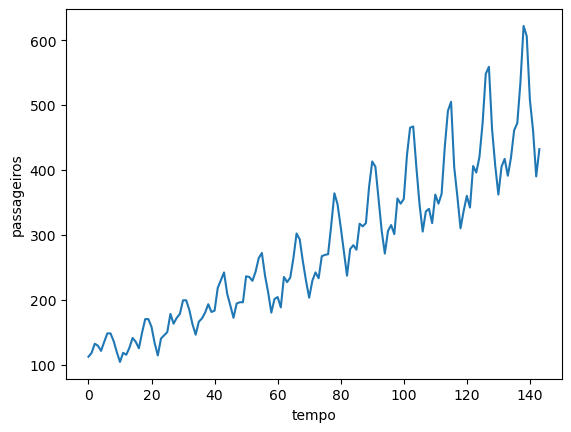

In [11]:
plt.plot(serie)
plt.xlabel("tempo")
plt.ylabel(x_names)
plt.show()

### 4.1 Sumarização estatística

In [12]:
def sumarizacao(serie, column):
    stats = []

    maximum = round(np.max(serie), 2)
    minimum = round(np.min(serie), 2)
    mean = round(np.mean(serie), 2)
    median = round(np.median(serie), 2)
    std = round(np.std(serie), 2)
    stats.append([column, maximum, minimum, mean, median, std])

    headers = ['Coluna', 'Máximo', 'Mínimo', 'Média', 'Mediana', 'Desvio Padrão']

    table = tabulate(stats, headers, tablefmt="pipe")
    print(table)

In [13]:
sumarizacao(serie, x_names)

| Coluna      |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:------------|---------:|---------:|--------:|----------:|----------------:|
| passageiros |      622 |      104 |   280.3 |     265.5 |          119.55 |


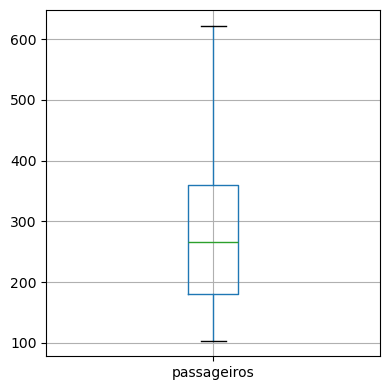

In [14]:
data.boxplot(column=x_names, figsize=(4, 4))
plt.tight_layout()
plt.show()

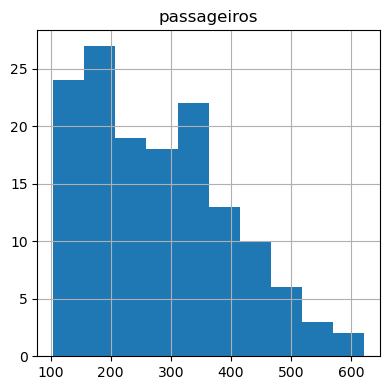

In [15]:
data.hist(column=x_names, figsize=(4, 4))
plt.tight_layout()
plt.show()

### 4.2 Verificando integridade dos dados

In [16]:
missing_counts = data.isnull().sum()
print("Total de dados faltantes por atributo:")
print(missing_counts)

Total de dados faltantes por atributo:
mes            0
passageiros    0
dtype: int64


### 4.3 Aplicando normalizacao e escala [0, 1]

In [17]:
def varianceEstabilization(serie, method):
    if method == 'asinh':
        return np.arcsinh(serie)
    elif method == 'log':
        return np.log(serie)
    else:
        return serie
    
def inverseVarianceEstabilization(serie, method):
    if method == 'asinh':
        return np.sinh(serie)
    elif method == 'log':
        return np.exp(serie)
    else:
        return serie

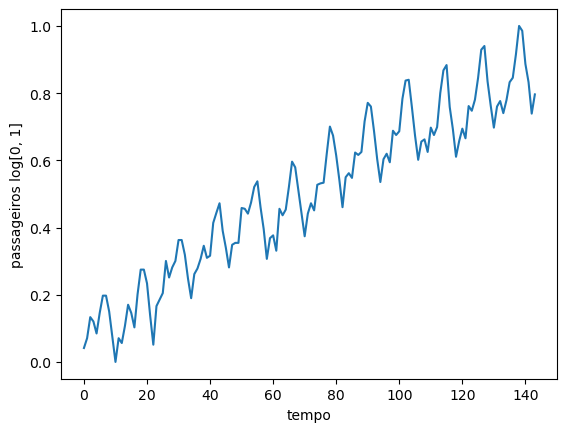

In [ ]:
#ajuste de dados
if data_adjust_exec:
    serie = varianceEstabilization(serie, norm_method)
    scaler = MinMaxScaler(feature_range=range_adjust)
    serie = scaler.fit_transform(serie) #fit_transform - transofrma a serie entre 0 e 1
    
plt.plot(serie)
plt.xlabel("tempo")
plt.ylabel(x_names + " log[0, 1]")
plt.show()

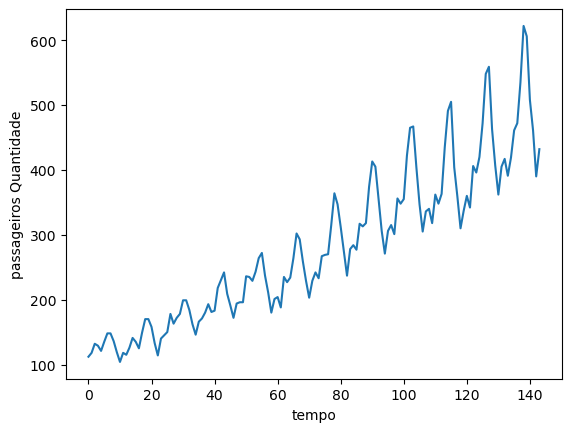

In [19]:
#desconversao de dados
serie_original = scaler.inverse_transform(serie)
serie_original = inverseVarianceEstabilization(serie_original, norm_method)

plt.plot(serie_original)
plt.xlabel("tempo")
plt.ylabel(x_names + " Quantidade")
plt.show()

## 5. Separacao dos conjuntos de dados (treino/validação e teste)

In [ ]:
#separa os conjuntos de treino/validacao e teste
trainval_size = int(len(serie) * 0.70) #70% dos valores para treino e 30% para teste
test_size = len(serie) - trainval_size
trainval, test = serie[0:trainval_size,:], serie[trainval_size:len(serie),:]

print(trainval.shape) #vai ver os 100
print(test.shape) #nunca vai ver os 44

(100, 1)
(44, 1)


### 5.1 Criação das janelas móveis

In [22]:
#cria os frames com base numa janela historica de dados
def create_frames(serie, back_window_size, forw_window_size):
    x_frames, y_frames = [], []
    
    for i in range(0, len(serie) - back_window_size - 1, forw_window_size):
        x_frames.append(serie[i:(i + back_window_size), 0])
        y_frames.append(serie[(i + back_window_size):(i + back_window_size) + forw_window_size, 0])
        #pega os 12 anteriores e preve os 2 para frente

    return np.array(x_frames), np.array(y_frames)

In [ ]:
#cria os frames
x_trainval, y_trainval = create_frames(trainval, size_hist_window, size_forw_window)
x_test, y_test = create_frames(test, size_hist_window, size_forw_window)

print(x_trainval.shape)#87 frames com 12 valores
print(y_trainval.shape)#87 frames respectivos com 1 valor
print(x_test.shape)#31 frames com 12 valores
print(y_test.shape)#31 frames respectivos com 1 valor

(87, 12)
(87, 1)
(31, 12)
(31, 1)


In [27]:
serie[0:13]#pegando os 13 primeiros pq a janela movel pega os 12 e preve o da frente

array([[0.04143333],
       [0.07061028],
       [0.1332953 ],
       [0.12044191],
       [0.08464718],
       [0.14585996],
       [0.19726276],
       [0.19726276],
       [0.14998603],
       [0.07532835],
       [0.        ],
       [0.07061028],
       [0.05621219]], dtype=float32)

In [ ]:
x_trainval[0:3]#os primeiros 12 valores sera o de treino e desolca de 1 em 1 para a proxima janela

array([[0.04143333, 0.07061028, 0.1332953 , 0.12044191, 0.08464718,
        0.14585996, 0.19726276, 0.19726276, 0.14998603, 0.07532835,
        0.        , 0.07061028],
       [0.07061028, 0.1332953 , 0.12044191, 0.08464718, 0.14585996,
        0.19726276, 0.19726276, 0.14998603, 0.07532835, 0.        ,
        0.07061028, 0.05621219],
       [0.1332953 , 0.12044191, 0.08464718, 0.14585996, 0.19726276,
        0.19726276, 0.14998603, 0.07532835, 0.        , 0.07061028,
        0.05621219, 0.10728574]], dtype=float32)

In [29]:
y_trainval[0:3]

array([[0.05621219],
       [0.10728574],
       [0.17017269]], dtype=float32)

In [ ]:
#ajustando para atender aos requisitos de entrada da LSTM: (amostras, timesteps, features)
#requisito do keras: qtd de amostras, timesteps - quantos passos deu para conseguir o tamanho da amostra
#features - quantidade de dados para fazer a previsao (nesse caso a coluna de passageiros)
x_trainval = np.expand_dims(x_trainval, axis=2)
y_trainval = np.expand_dims(y_trainval, axis=2)
x_test = np.expand_dims(x_test, axis=2)
y_test = np.expand_dims(y_test, axis=2)

print(x_trainval.shape)
print(y_trainval.shape)
print(x_test.shape)
print(y_test.shape)

(87, 12, 1)
(87, 1, 1)
(31, 12, 1)
(31, 1, 1)


## 6. Treinamento do modelo

### 6.1 Construção do modelo

In [31]:
#-----------------
#CRIAÇÃO DO MODELO BASEADO EM LSTM
#-----------------

# Configurações de neurônios
units_lstm1 = 16
units_lstm2 = 32
units_lstm3 = 32
units_dense = 16

# Funções de ativação
actfunc_lstm1 = 'tanh'
actfunc_lstm2 = 'tanh'
actfunc_lstm3 = 'tanh'
actfunc_dense = 'tanh'
actfunc_output = 'tanh'

#inicializador
initializer = tensorflow.keras.initializers.LecunNormal(seed=42)

# Criação das entradas de treino+validação
inputs = Input(shape=(x_trainval.shape[1], x_trainval.shape[2]), name="x_train")
#qtd de dados, qtd de features (12, 1)

# Camada LSTM 1
layer_lstm1 = LSTM(units_lstm1, 
                    activation=actfunc_lstm1, 
                    return_sequences=True,
                    kernel_initializer=initializer)(inputs)

# Camada LSTM 2
layer_lstm2 = LSTM(units_lstm2, 
                    activation=actfunc_lstm2, 
                    return_sequences=True,
                    kernel_initializer=initializer)(layer_lstm1)

# Camada LSTM 3
layer_lstm3 = Bidirectional(LSTM(units_lstm3, #bidirectional - inverte e volta pro neuronio
                                activation=actfunc_lstm3, 
                                return_sequences=False,
                                kernel_initializer=initializer))(layer_lstm2)

# Camada densa final para ajustar o formato da saída
layer_dense = Dense(units_dense, activation=actfunc_dense)(layer_lstm3)

# Camada densa final para ajustar o formato da saída
layer_dense_out = Dense(y_trainval.shape[1], activation=actfunc_output)(layer_dense)

# Criação do modelo - conecta o input com o output
model_trained = Model(inputs=inputs, outputs=layer_dense_out)

2025-12-12 10:59:59.466728: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-12 10:59:59.467064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-12 10:59:59.467210: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### 6.2 Inspecionando o modelo

h = 1
h - 1 = 16
entrada no neuronio seguinte = (1 + 16) = 17
pesos entre a entrada e as celulas = 17 * 16 = 272
para cada neuronio adiciona o bias = 272 + 16 = 288
para cada portao = 288 * 4 = 1152

In [32]:
model_trained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_train (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 12, 16)            1152      
                                                                 
 lstm_1 (LSTM)               (None, 12, 32)            6272      
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                             

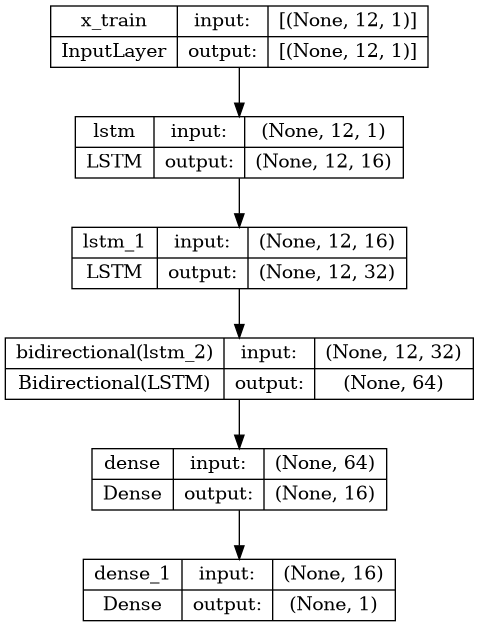

In [33]:
plot_model(model_trained, show_shapes=True, show_layer_names=True, rankdir="TB")  #TB para plotar na vertical

### 6.3 Otimização do modelo

In [34]:
if new_model:
    #com o AirPassenger não usa validacao
    if (use_dataset == 'AP'):
        cp = ModelCheckpoint(
            filepath='models/' + model_name + '_model_trained.weights.h5',
            save_weights_only=True,
            monitor='loss', #monitorar so a funcao de perda principal (loss)
            mode='min',
            save_best_only=True
        )
        validation_size = 0.0 #sem validacao pq o dataset é pequeno

        es = EarlyStopping(monitor='loss', mode='min', patience=200)

    #com o Banco do Brasil usa validacao
    if (use_dataset == 'BB'):
        cp = ModelCheckpoint(
            filepath='models/' + model_name + '_model_trained.weights.h5',
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True
        )
        validation_size = 0.2

        es = EarlyStopping(monitor='val_loss', mode='min', patience=200)

    
    opt = Adam(learning_rate=0.0001)
    model_trained.compile(optimizer=opt, loss='mean_squared_error')

    history = model_trained.fit(
        x_trainval,
        y_trainval,
        validation_split=validation_size,
        epochs=500,
        verbose=1,
        callbacks=[cp, es],
        batch_size=1,
        shuffle=False
    )

    np.save('models/' + model_name + '_history_model.npy', history.history)
    model_trained.load_weights('models/' + model_name + '_model_trained.weights.h5')
    model_trained.save('models/' + model_name + '.keras')
else:
    model_trained = load_model('models/' + model_name + '.keras')

Epoch 1/500


2025-12-12 11:05:29.712400: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-12-12 11:05:30.055063: I external/local_xla/xla/service/service.cc:168] XLA service 0x7e6078c37300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-12 11:05:30.055090: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-12-12 11:05:30.067372: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765548330.149219   13502 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


87/87 [==============================] - 4s 5ms/step - loss: 0.0063
Epoch 2/500
87/87 [==============================] - 0s 4ms/step - loss: 0.0076
Epoch 3/500
87/87 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 4/500
87/87 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 5/500
87/87 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 6/500
87/87 [==============================] - 0s 4ms/step - loss: 0.0058
Epoch 7/500
87/87 [==============================] - 0s 4ms/step - loss: 0.0058
Epoch 8/500
87/87 [==============================] - 0s 4ms/step - loss: 0.0058
Epoch 9/500
87/87 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 10/500
87/87 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 11/500
87/87 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 12/500
87/87 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 13/500
87/87 [=============================

### 6.4 Avaliação do modelo com curva de convergência

Descomente este código se você estiver realizando testes com conjunto de validação para ver a curva de convergência

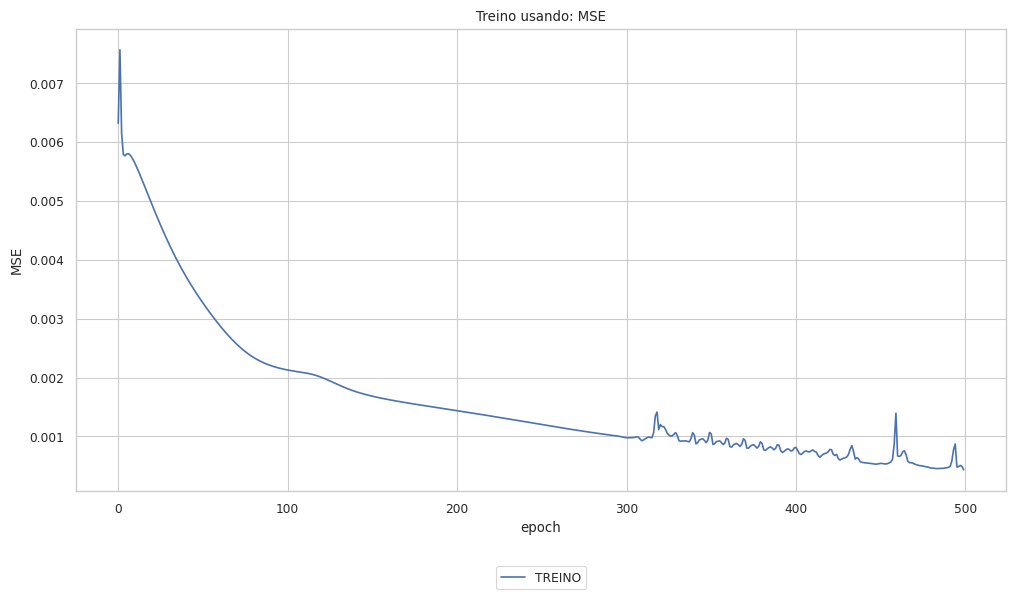

In [35]:
history=np.load('models/' + model_name + '_history_model.npy', allow_pickle='TRUE').item()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

train_metric = history['loss']

if (use_dataset == 'BB'):
    valid_metric = history['val_loss']
    
name_metric = 'mse'

fig = plt.figure()

plt.plot(train_metric, label='TREINO')

if (use_dataset == 'BB'):
    plt.plot(valid_metric, label='VALIDAÇÃO')

plt.ylabel(name_metric.upper())
plt.xlabel('epoch')

if (use_dataset == 'BB'):
    plt.title('Treino vs. Validação usando: ' + name_metric.upper())
else:
    plt.title('Treino usando: ' + name_metric.upper())
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)

plt.show()

## 7. Testando as previsões

### 7.1 Gerando as previsões com o modelo treinado

In [36]:
test[0:13]

array([[0.68643403],
       [0.78309846],
       [0.8373506 ],
       [0.8397505 ],
       [0.7587261 ],
       [0.6736901 ],
       [0.6015568 ],
       [0.655679  ],
       [0.6622956 ],
       [0.62489414],
       [0.69735146],
       [0.6752989 ],
       [0.698894  ]], dtype=float32)

In [37]:
x_test[0:1]

array([[[0.68643403],
        [0.78309846],
        [0.8373506 ],
        [0.8397505 ],
        [0.7587261 ],
        [0.6736901 ],
        [0.6015568 ],
        [0.655679  ],
        [0.6622956 ],
        [0.62489414],
        [0.69735146],
        [0.6752989 ]]], dtype=float32)

In [38]:
y_test[0:1]

array([[[0.698894]]], dtype=float32)

In [39]:
if (use_dataset == 'AP'):
    #AIR PASSENGER
    #pega os dados reais e volta para a escala original - air passenger
    y_true = scaler.inverse_transform(y_test.reshape(y_test.shape[0],1))
    y_true = inverseVarianceEstabilization(y_true, norm_method).flatten()

In [40]:
if (use_dataset == 'BB'):
    #BANCO DO BRASIL
    #pega os dados reais e volta para a escala original - bbas3
    y_true = scaler.inverse_transform(y_test.reshape(y_test.flatten().shape[0],1))
    y_true = inverseVarianceEstabilization(y_true, norm_method).flatten()

In [41]:
y_true

array([363.00006, 435.00003, 490.9999 , 504.99994, 403.9999 , 358.99994,
       310.00006, 336.99997, 360.00003, 341.99994, 406.00006, 396.     ,
       419.99994, 471.99997, 548.0001 , 559.00006, 463.     , 407.00006,
       361.99994, 405.     , 417.00003, 390.99994, 419.     , 460.9999 ,
       471.99997, 535.     , 622.0001 , 606.0001 , 508.0001 , 460.9999 ,
       390.     ], dtype=float32)

In [42]:
y_true.shape

(31,)

In [43]:
#realiza as previsoes do modelo treinado no conjunto de testes e volta para a escala original
y_hat = model_trained.predict(x_test)

1/1 [==============================] - 1s 834ms/step


In [44]:
#pega os dados previstos e coloca na escala original
y_hat = scaler.inverse_transform(y_hat)
y_hat = inverseVarianceEstabilization(y_hat, norm_method).flatten()
y_hat.shape

(31,)

### 7.2 Avaliando as previsões

In [45]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def printRegressionMetrics(y_true, y_pred):
    
    MAPE = mape(y_true, y_pred)
    R2 = metrics.r2_score(y_true, y_pred)
    
    print('MAPE:')
    print(MAPE)
    print('R2:')
    print(R2)

In [46]:
printRegressionMetrics(y_true, y_hat)

MAPE:
11.863653361797333
R2:
0.1583871841430664


In [47]:
if (use_dataset == 'AP'):
    #AIR PASSENGER
    #pega os valores reais anteriores ao ponto de previsao - air passenger
    y_true_trainval = y_trainval.flatten().reshape(len(y_trainval),1)
    y_true_trainval = scaler.inverse_transform(y_true_trainval)
    y_true_trainval = inverseVarianceEstabilization(y_true_trainval, norm_method).flatten()

In [48]:
if (use_dataset == 'BB'):
    #BANCO DO BRASIL
    #pega os valores reais anteriores ao ponto de previsao - bbas3
    y_true_trainval = y_trainval.flatten().reshape(len(y_trainval.flatten()),1)
    y_true_trainval = scaler.inverse_transform(y_true_trainval)
    y_true_trainval = inverseVarianceEstabilization(y_true_trainval, norm_method).flatten()

In [49]:
y_true_trainval.shape

(87,)

In [50]:
#cria um data table com os valores reais e preditos
df_forecast = pd.DataFrame()
df_forecast['y_true'] = np.hstack((y_true_trainval, y_true))
df_forecast['y_hat'] = np.hstack((y_true_trainval, y_hat))

df_forecast.shape

(118, 2)

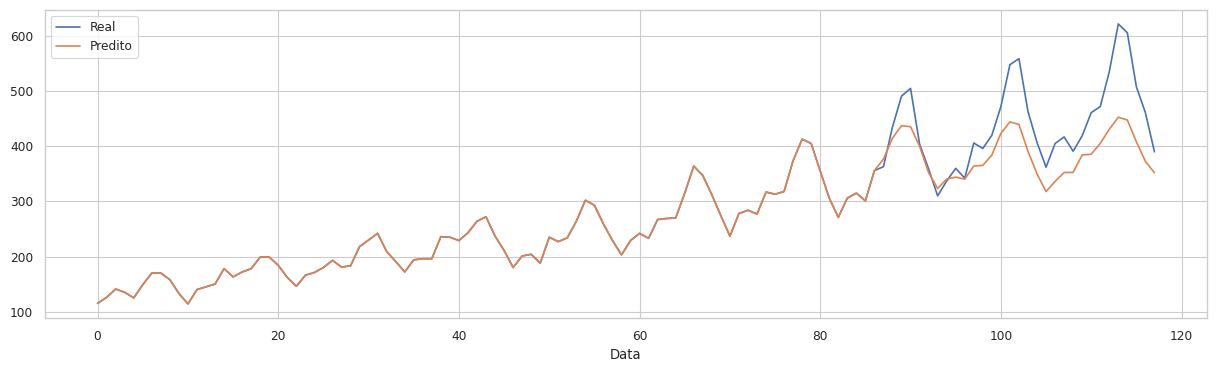

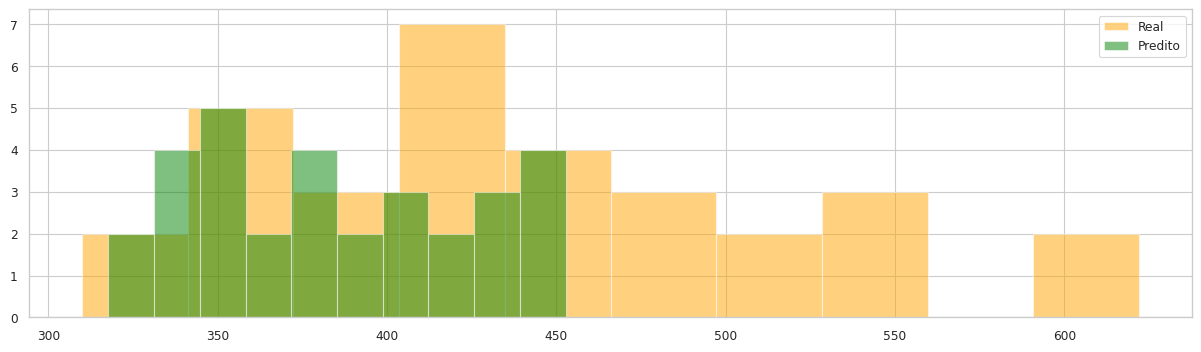

In [51]:
sns.set(rc={'figure.figsize':(15, 4)})
sns.set_style('whitegrid')
sns.set_context('paper')

ax = df_forecast.plot(x_compat=True, style='-')
ax.set_xlabel("Data")
ax.legend(["Real", "Predito"])

plt.grid(True)

plt.show()

plt.close()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(figsize=(15, 4))
plt.hist(y_true, bins=10, color='orange', alpha=0.5, label='Real')
plt.hist(y_hat, bins=10, color='green', alpha=0.5, label='Predito')
plt.legend()

plt.show()

plt.close()

In [ ]:
#toca um som para avisar que terminou de executar
pygame.mixer.init()
arquivo_mp3 = 'support_files/mario_coin.mp3'
pygame.mixer.music.load(arquivo_mp3)
pygame.mixer.music.play()

while pygame.mixer.music.get_busy():
    continue
    
print('Sucesso!')